### 1. Load libraries

In [ ]:
import importlib
import pandas as pd
# from pandas.testing import assert_frame_equal
import numpy as np
from pathlib import Path
import gc, json, os, tempfile
import dataloader, databalancer, datatrainer, modeleval
importlib.reload(dataloader)
importlib.reload(databalancer)
importlib.reload(datatrainer)
importlib.reload(modeleval)
from dataloader import read_imputed_datasets_hdf5, load_and_transform_data, prep_tensor
from databalancer import df_event_focus, rebalance_data
from datatrainer import recursive_clustering
from modeleval import test_model, nam_dagostino_chi2, get_baseline_hazard_at_timepoints, calculate_null_brier
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import brier_score_loss
from sklearn.utils import resample
from lifelines import KaplanMeierFitter, AalenJohansenFitter, CoxPHFitter
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv
from scipy.stats import chi2, norm
import psutil 


gc.collect()

### 2. Load constants and datasets

In [ ]:
RANDOM_SEED = 12345
feature_col = ['gender', 'dm', 'ht', 'sprint', 'a1c', 'po4', 'UACR_mg_g', 'Cr', 'age', 'alb', 'ca', 'hb', 'hco3']
duration_col = ['date_from_sub_60']
event_col = ['endpoint']
cluster_col = ['key']

# Define your feature groups
cat_features = ['gender', 'dm', 'ht', 'sprint']
log_features = ['a1c', 'po4', 'UACR_mg_g', 'Cr']
standard_features = ['age', 'alb', 'ca', 'hb', 'hco3']
passthrough_features = ['key', 'date_from_sub_60', 'endpoint']

base_filename = '/mnt/d/pydatascience/g3_regress/data/X/X_20240628'
X_load = read_imputed_datasets_hdf5(base_filename)
test_df = X_load['X_test_main'][0]
test_df = df_event_focus(df=test_df, event_col=event_col, event_focus=1)
X_test = test_df[feature_col].copy()
y_test = test_df[duration_col + event_col].copy()

# Impute X_test:
if X_test.isnull().values.any():
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=RANDOM_SEED,
                                initial_strategy='mean', n_nearest_features=None, min_value=1e-6,
                                imputation_order='ascending')
    X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)
    
# Constants based on gender
X_test['Cr_mg_dL'] = X_test['Cr'] / 88.4
conditions = [
    X_test['gender'] == 0,  # Female
    X_test['gender'] == 1   # Male
]

choices_k = [0.7, 0.9]  # kappa values for female and male
choices_alpha = [-0.241, -0.302]  # alpha values for female and male
X_test['kappa'] = np.select(conditions, choices_k, default=np.nan)
X_test['alpha'] = np.select(conditions, choices_alpha, default=np.nan)

# Calculate eGFR using the CKD-EPI 2021 equation
X_test['eGFR'] = 142 * (X_test['Cr_mg_dL'] / X_test['kappa']).clip(upper=1)**X_test['alpha'] * \
                        (X_test['Cr_mg_dL'] / X_test['kappa']).clip(lower=1)**(-1.2) * \
                        0.9938**X_test['age']

### 3. Code the KFRE
- Tangri N, Grams ME, Levey AS, Coresh J, Appel LJ, Astor BC, et al. Multinational Assessment of Accuracy of Equations for Predicting Risk of Kidney Failure: A Meta-analysis. JAMA. 2016;315(2): 164–174. https://doi.org/10.1001/jama.2015.18202.

#### 4-variable 2-yr calibrated non-American equation
- 1 - 0.9832^exp(-0.2201 x (age/10 – 7.036) + 0.2467 x (male – 0.5642) – 0.5567 x (eGFR/5 – 7.222) + 0.4510 x (logACR – 5.137))
#### 8-variable 2-yr calibrated non-American equation
- 1 – 0.9827 ^ exp (-0.1992 × (age/10 – 7.036) + 0.1602 × (male – 0.5642) – 0.4919 × (eGFR/5 – 7.222) + 0.3364 × (logACR – 5.137) – 0.3441 × (albumin – 3.997) + 0.2604 × (phosphorous – 3.916) – 0.07354 × (bicarbonate – 25.57) – 0.2228 × (calcium – 9.355))
#### 4-variable 5-yr calibrated non-American equation
- 1 – 0.9365 ^ exp (-0.2201 × (age/10 – 7.036) + 0.2467 × (male – 0.5642) – 0.5567 × (eGFR/5 – 7.222) + 0.4510 × (logACR – 5.137))
#### 8-variable 5-yr calibrated non-American equation
- 1 – 0.9245 ^ exp (-0.1992 × (age/10 – 7.036) + 0.1602 × (male – 0.5642) – 0.4919 × (eGFR/5 – 7.222) + 0.3364 × (logACR – 5.137) – 0.3441 × (albumin – 3.997) + 0.2604 × (phosphorous – 3.916) – 0.07354 × (bicarbonate – 25.57) – 0.2228 × (calcium – 9.355))

In [145]:
# Define risk calculation functions
def calculate_4_variable_2yr_risk(row):
    return 1 - 0.9832**np.exp(-0.2201 * (row['age'] / 10 - 7.036) + 
                              0.2467 * (row['gender'] - 0.5642) - 
                              0.5567 * (row['eGFR'] / 5 - 7.222) + 
                              0.4510 * (np.log(row['UACR_mg_g']) - 5.137))

def calculate_8_variable_2yr_risk(row):
    return 1 - 0.9827**np.exp(-0.1992 * (row['age'] / 10 - 7.036) + 
                              0.1602 * (row['gender'] - 0.5642) - 
                              0.4919 * (row['eGFR'] / 5 - 7.222) + 
                              0.3364 * (np.log(row['UACR_mg_g']) - 5.137) - 
                              0.3441 * (row['alb'] - 3.997) + 
                              0.2604 * (row['po4'] - 3.916) - 
                              0.07354 * (row['hco3'] - 25.57) - 
                              0.2228 * (row['ca'] - 9.355))

def calculate_4_variable_5yr_risk(row):
    return 1 - 0.9365**np.exp(-0.2201 * (row['age'] / 10 - 7.036) + 
                              0.2467 * (row['gender'] - 0.5642) - 
                              0.5567 * (row['eGFR'] / 5 - 7.222) + 
                              0.4510 * (np.log(row['UACR_mg_g']) - 5.137))

def calculate_8_variable_5yr_risk(row):
    return 1 - 0.9245**np.exp(-0.1992 * (row['age'] / 10 - 7.036) + 
                              0.1602 * (row['gender'] - 0.5642) - 
                              0.4919 * (row['eGFR'] / 5 - 7.222) + 
                              0.3364 * (np.log(row['UACR_mg_g']) - 5.137) - 
                              0.3441 * (row['alb'] - 3.997) + 
                              0.2604 * (row['po4'] - 3.916) - 
                              0.07354 * (row['hco3'] - 25.57) - 
                              0.2228 * (row['ca'] - 9.355))
    
pred_df = pd.DataFrame(index=X_test.index)
pred_df['4v2y'] = X_test.apply(calculate_4_variable_2yr_risk, axis=1) 
pred_df['8v2y'] = X_test.apply(calculate_8_variable_2yr_risk, axis=1) 
pred_df['4v5y'] = X_test.apply(calculate_4_variable_5yr_risk, axis=1) 
pred_df['8v5y'] = X_test.apply(calculate_8_variable_5yr_risk, axis=1)

### 4. Bootstrap 500 times

In [87]:
def calculate_null_brier(durations, events, time_grid, event_of_interest=1):
    """
    Calculate the null model Brier score for a given set of durations and events.

    Args:
        durations (array-like): Event/censoring times.
        events (array-like): Event indicators (1 for event, 0 for censoring).
        time_grid (list): List of time points for evaluation.
        event_of_interest (int): The event type of interest for competing risks.

    Returns:
        float: Integrated Brier score for the null model.
    """
    
    def interpolate_cif(cif, time_points):
        cif_values = cif.values.squeeze()
        cif_index = cif.index.values
        max_time = cif_index[-1]
        max_cif_value = cif_values[-1]
        
        # Interpolation within range
        interpolated = np.interp(time_points, cif_index, cif_values)
        
        # Handle extrapolation for times > max_time
        interpolated[time_points > max_time] = max_cif_value
        
        return interpolated
    # Ensure durations and events are NumPy arrays
    durations = durations.squeeze()
    events = events.squeeze()
    
    # # Resolve ties in event times by adding small noise
    # unique_durations, counts = np.unique(durations, return_counts=True)
    # tied_indices = np.isin(durations, unique_durations[counts > 1])
    # noise = np.random.uniform(low=-1e-6, high=1e-6, size=len(durations))
    # durations[tied_indices] += noise[tied_indices]

    # Fit Aalen-Johansen estimator
    kmf = KaplanMeierFitter()
    kmf.fit(durations, events)
    cif = kmf.cumulative_density_
    
    # Calculate survival probabilities
    surv_probs = 1 - interpolate_cif(cif, time_grid) 
    # Create survival probability DataFrame for EvalSurv
    surv_df = pd.DataFrame(
        np.tile(surv_probs, (len(durations), 1)).T, index=time_grid
    )

    # Evaluate using EvalSurv
    ev = EvalSurv(surv_df, durations, events == event_of_interest, censor_surv="km")

    # Integrated Brier score
    brier = ev.brier_score(time_grid)
    return brier


In [ ]:
bootstrap_results = []
# Initialize storage for bootstrapped results
null_brier_scores = {}
# Number of bootstraps
n_bootstraps = 500

for i in range(n_bootstraps):
    print(f'On {i+1}th bootstrap:')
    # Resample with replacement
    X_test_bootstrap = X_test[X_test.index.isin(resample(X_test.index))]
    y_test_bootstrap = y_test.iloc[X_test_bootstrap.index,:]
    
    # Calculate KFRE risks
    pred_df = pd.DataFrame(index=X_test_bootstrap.index)
    pred_df['4v2y'] = X_test_bootstrap.apply(calculate_4_variable_2yr_risk, axis=1)
    pred_df['8v2y'] = X_test_bootstrap.apply(calculate_8_variable_2yr_risk, axis=1)
    pred_df['4v5y'] = X_test_bootstrap.apply(calculate_4_variable_5yr_risk, axis=1)
    pred_df['8v5y'] = X_test_bootstrap.apply(calculate_8_variable_5yr_risk, axis=1)
    
# Calculate null Brier scores for each time grid
    null_brier_scores[i] = calculate_null_brier(
            y_test_bootstrap[duration_col].values,
            y_test_bootstrap[event_col].values,
            np.array([730, 1825])
            )    
    
    for time in np.array([2 * 365, 5 * 365]):
        for c in pred_df.columns:
            prob_df = pd.DataFrame({
                'predicted_probs': pred_df[c].values,
                'observed_probs': np.nan  # Placeholder for observed probabilities
            }, index=y_test_bootstrap.index)
            prob_df['quantile'] = pd.qcut(prob_df['predicted_probs'], 5, labels=False, duplicates='drop')
            prob_df['quantile'] = prob_df['quantile'].astype(int)
                
            observed_probs = []
            for q in prob_df['quantile'].unique():
                mask = prob_df['quantile'] == q
                durations = y_test_bootstrap.loc[mask, duration_col[0]].astype(float)
                event_observed = y_test_bootstrap.loc[mask, event_col[0]]
                kmf = KaplanMeierFitter()
                kmf.fit(durations=durations, event_observed=event_observed)
                
                if time not in kmf.cumulative_density_.index:
                    closest_idx = kmf.cumulative_density_.index.get_indexer([time], method='nearest')[0]
                    closest_time = kmf.cumulative_density_.index[closest_idx]
                else:
                    closest_time = time
                observed_probs.append(kmf.cumulative_density_.loc[closest_time].values[0]) 
                
            prob_df['observed_probs'] = prob_df['quantile'].map(dict(zip(prob_df['quantile'].unique(), observed_probs)))
            grouped = prob_df.groupby('quantile')
            observed_events = grouped['observed_probs'].mean()
            expected_events = grouped['predicted_probs'].mean()
            n = grouped.size()        
            
        
            chi2_stat = np.sum(((observed_events - expected_events) ** 2) / (expected_events * (1 - expected_events / n)))
            dof = len(n) - 2
            p_value = 1 - chi2.cdf(chi2_stat, dof)
            brier_score = brier_score_loss(y_test_bootstrap[event_col[0]], prob_df['predicted_probs'])
            c_index = concordance_index(y_test_bootstrap[duration_col[0]], -prob_df['predicted_probs'], y_test_bootstrap[event_col[0]])

            # Store bootstrap result
            bootstrap_results.append({
                'time': time,
                'column': c,
                'brier_score': brier_score,
                'c_index': c_index,
                'chi2_stat': chi2_stat,
                'p_value': p_value,
                'null_brier_score': null_brier_scores[i][time]
            })        
    print('done.')    
bootstrap_results

In [192]:
bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df.loc[bootstrap_df['null_brier_score'] == 0, 'null_brier_score'] = np.nan
bootstrap_df['null_brier_score'] = bootstrap_df['null_brier_score'].fillna(1e-7)
bootstrap_df['ipa'] = 1 - (bootstrap_df['brier_score']/bootstrap_df['null_brier_score'])
# Aggregate metrics
summary = bootstrap_df.groupby(['time', 'column']).agg(
    mean_brier=('brier_score', 'mean'),
    ci_lower_brier=('brier_score', lambda x: np.percentile(x, 2.5)),
    ci_upper_brier=('brier_score', lambda x: np.percentile(x, 97.5)),
    mean_c_index=('c_index', 'mean'),
    ci_lower_c_index=('c_index', lambda x: np.percentile(x, 2.5)),
    ci_upper_c_index=('c_index', lambda x: np.percentile(x, 97.5)),
    mean_chi2=('chi2_stat', 'mean'),
    mean_p_value=('p_value', 'mean'),
    mean_null_brier=('null_brier_score', 'mean'),
    ci_lower_null_brier=('null_brier_score', lambda x: np.percentile(x, 2.5)),
    ci_upper_null_brier=('null_brier_score', lambda x: np.percentile(x, 97.5)),
    mean_ipa=('ipa', 'mean'),
    ci_lower_ipa=('ipa', lambda x: np.percentile(x, 2.5)),
    ci_upper_ipa=('ipa', lambda x: np.percentile(x, 97.5)),
).reset_index()
print(summary)

   time column  mean_brier  ci_lower_brier  ci_upper_brier  mean_c_index  \
0   730   4v2y    0.048521        0.047433        0.049677      0.969869   
1   730   4v5y    0.131544        0.129508        0.133618      0.969869   
2   730   8v2y    0.004939        0.004404        0.005476      0.916580   
3   730   8v5y    0.004964        0.004414        0.005497      0.916580   
4  1825   4v2y    0.048521        0.047433        0.049677      0.969869   
5  1825   4v5y    0.131544        0.129508        0.133618      0.969869   
6  1825   8v2y    0.004939        0.004404        0.005476      0.916580   
7  1825   8v5y    0.004964        0.004414        0.005497      0.916580   

   ci_lower_c_index  ci_upper_c_index      mean_chi2  mean_p_value  \
0          0.966008          0.974000       0.425164      0.934994   
1          0.966008          0.974000       0.932731      0.817523   
2          0.907176          0.926004      16.854769      0.010170   
3          0.907176          0.9260

In [193]:
final_df = summary.loc[[0,2,5,7], :]
final_df.to_json('/mnt/d/pydatascience/g3_regress/data/results/kfre_bootstrap.json', orient='records', lines=True)

In [194]:
final_df

,time,column,mean_brier,ci_lower_brier,ci_upper_brier,mean_c_index,ci_lower_c_index,ci_upper_c_index,mean_chi2,mean_p_value,mean_null_brier,ci_lower_null_brier,ci_upper_null_brier,mean_ipa,ci_lower_ipa,ci_upper_ipa
0,730,4v2y,0.048521,0.047433,0.049677,0.969869,0.966008,0.974000,0.425164,0.934994,0.007130,0.006122,0.008070,-5.839005,-6.935502,-5.000224
2,730,8v2y,0.004939,0.004404,0.005476,0.916580,0.907176,0.926004,16.854769,0.010170,0.007130,0.006122,0.008070,0.305851,0.236023,0.362111
5,1825,4v5y,0.131544,0.129508,0.133618,0.969869,0.966008,0.974000,0.396637,0.939604,0.586121,0.212797,0.916782,-23632.098240,0.378332,0.856758
7,1825,8v5y,0.004964,0.004414,0.005497,0.916580,0.907176,0.926004,109729.337961,0.000000,0.586121,0.212797,0.916782,-891.660616,0.975606,0.994953


### 5. Plot the risk against quantile of predicted risk

In [176]:
pred_df = pd.DataFrame(index=X_test.index)
pred_df['4v2y'] = X_test.apply(calculate_4_variable_2yr_risk, axis=1) 
pred_df['8v2y'] = X_test.apply(calculate_8_variable_2yr_risk, axis=1) 
pred_df['4v5y'] = X_test.apply(calculate_4_variable_5yr_risk, axis=1) 
pred_df['8v5y'] = X_test.apply(calculate_8_variable_5yr_risk, axis=1)

quantiles = np.arange(5)
time_points = np.array([2 * 365, 5 * 365])

data = {
    "Time Point": [],
    "KFRE": [],
    "Quantile": [],
    "Predicted": [],
    "Observed": [],
    "Quantile Label": []    
}

for time in np.array([2*365, 5*365]):
    for c in pred_df.columns:
        prob_df = pd.DataFrame({
            'predicted_probs': pred_df[c].values,
            'observed_probs': np.nan  # Placeholder for observed probabilities
        }, index=y_test.index)
        prob_df['quantile'], bin_edges = pd.qcut(prob_df['predicted_probs'], 10, retbins=True, labels=False, duplicates='drop')
        quantile_labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)]        
        prob_df['quantile'] = prob_df['quantile'].astype(int)

        observed_probs = []
        for q in prob_df['quantile'].unique():
            mask = prob_df['quantile'] == q
            durations = pd.Series(y_test.loc[mask, duration_col[0]].values.ravel(), index=y_test.loc[mask, duration_col[0]].index).astype(float)
            event_observed = pd.Series(y_test.loc[mask, event_col[0]].values.ravel(), index=y_test.loc[mask, event_col[0]].index)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=durations, event_observed=event_observed)
            # Find the closest time point if `time` is not in the index
            if time not in kmf.cumulative_density_.index:
                closest_idx = kmf.cumulative_density_.index.get_indexer([time], method='nearest')[0]
                closest_time = kmf.cumulative_density_.index[closest_idx]
            else:
                closest_time = time
            observed_probs.append(kmf.cumulative_density_.loc[closest_time].values[0])
        prob_df['observed_probs'] = prob_df['quantile'].map(dict(zip(prob_df['quantile'].unique(), observed_probs)))
        grouped = prob_df.groupby('quantile')
        observed_events = grouped['observed_probs'].mean()
        expected_events = grouped['predicted_probs'].mean()        
        # Append data to `data` dictionary
        for q in prob_df['quantile'].unique():
            data['KFRE'].append(c)
            data['Time Point'].append(time)
            data['Quantile'].append(q)
            data['Quantile Label'].append(quantile_labels[q])            
            data['Predicted'].append(expected_events[q])
            data['Observed'].append(observed_events[q])
            
risk_plot_df = pd.DataFrame(data)
risk_plot_df["Predicted"] =  risk_plot_df["Predicted"] * 100
risk_plot_df["Observed"] =  risk_plot_df["Observed"] * 100

In [196]:
risk_plot_df

,Time Point,KFRE,Quantile,Predicted,Observed,Quantile Label
0,730,4v2y,2,0.115514,0.000000,0.00-0.00
1,730,4v2y,4,0.610931,0.000000,0.00-0.01
2,730,4v2y,3,0.281498,0.000000,0.00-0.00
3,730,4v2y,0,0.000078,0.000000,0.00-0.00
4,730,4v2y,5,1.348453,0.000000,0.01-0.02
...,...,...,...,...,...,...
75,1825,8v5y,7,0.000907,100.000000,0.00-0.00
76,1825,8v5y,8,0.004247,33.259794,0.00-0.00
77,1825,8v5y,6,0.000289,1.224267,0.00-0.00
78,1825,8v5y,1,0.000002,0.000000,0.00-0.00


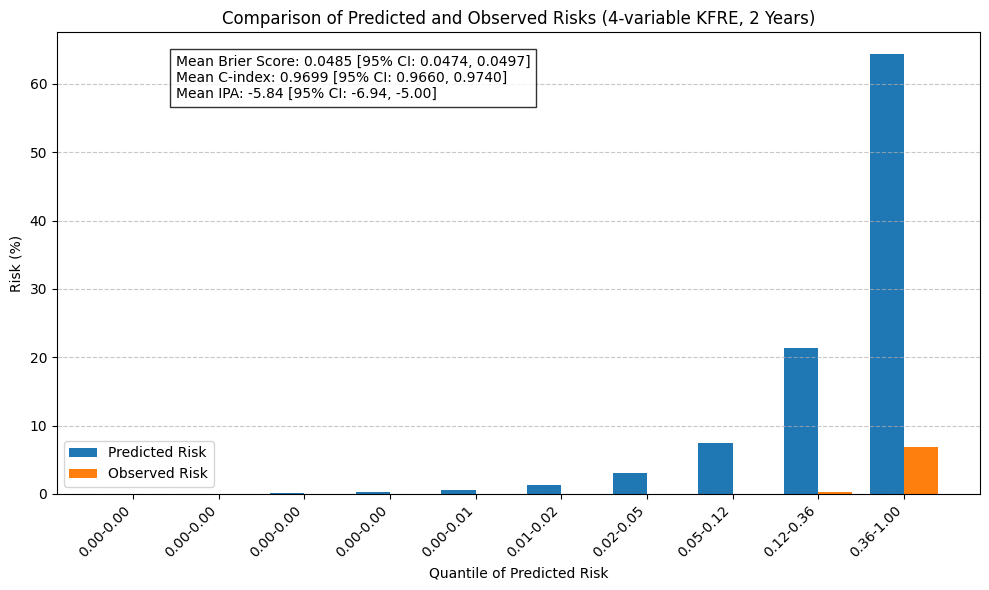

In [195]:
import matplotlib.pyplot as plt

plot_data = risk_plot_df.loc[(risk_plot_df['KFRE'] == '4v2y') & (risk_plot_df['Time Point'] == 730)]
# Extract metrics dynamically from final_df
metrics_row = final_df[(final_df['time'] == 730) & (final_df['column'] == '4v2y')].iloc[0]
metrics_text = (
    f"Mean Brier Score: {metrics_row['mean_brier']:.4f} [95% CI: {metrics_row['ci_lower_brier']:.4f}, {metrics_row['ci_upper_brier']:.4f}]\n"
    f"Mean C-index: {metrics_row['mean_c_index']:.4f} [95% CI: {metrics_row['ci_lower_c_index']:.4f}, {metrics_row['ci_upper_c_index']:.4f}]\n"
    f"Mean IPA: {metrics_row['mean_ipa']:.2f} [95% CI: {metrics_row['ci_lower_ipa']:.2f}, {metrics_row['ci_upper_ipa']:.2f}]"
)

# Plot
plt.figure(figsize=(10, 6))
x = plot_data['Quantile']
width = 0.4  # width of the bars

# Plot predicted and observed risks
plt.bar(x - width/2, plot_data['Predicted'], width=width, label='Predicted Risk')
plt.bar(x + width/2, plot_data['Observed'], width=width, label='Observed Risk')

# Add labels and title
plt.xlabel('Quantile of Predicted Risk')
plt.ylabel('Risk (%)')
plt.title('Comparison of Predicted and Observed Risks (4-variable KFRE, 2 Years)')
plt.xticks(ticks=x, labels=plot_data['Quantile Label'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

text_x = 0.5  # X-coordinate for the text annotations
text_y = max(plot_data['Predicted'].max(), plot_data['Observed'].max()) * 0.9  # Position the text at 90% of the highest bar
plt.text(text_x, text_y, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# Save the plot as JPEG with 1000 DPI
output_path = "/mnt/d/PYDataScience/g3_regress/data/results/4v2y_risk_comparison.jpeg"
plt.savefig(output_path, format="jpeg", dpi=1000)
plt.show()
plt.close()

